In [1295]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly.express as px
import time
import geopy.distance
from geopy.geocoders import Nominatim
import geocoder 
from sklearn.base import TransformerMixin, BaseEstimator
from collections import Counter
import category_encoders as ce
from sklearn import linear_model
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import optuna
from functions import *
import logging
import warnings 

warnings.filterwarnings("ignore")

In [1296]:
fmt = '%(asctime)s %(levelname)s %(lineno)s %(message)s'
logging.basicConfig(level='INFO', format=fmt, filename='log.log', filemode='a') 
logger = logging.getLogger('logit')

In [1297]:
df_cottage = pd.read_csv('data/country_houses_2.csv').drop(['Unnamed: 0'], axis=1)
print(df_cottage.shape)
print(f"Duplicates found: {df_cottage[df_cottage.duplicated].shape[0]}")
df_cottage.head(3)


(13135, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Ширина застройки,Длина застройки,Год постройки,Материал стен,Материал крыши,Ремонт,Отопление,...,Элитный коттедж,Камин,Хозпостройки,Строительные материалы,Направление,Мебель,Баня,Пруд на участке,Новостройка,Аукцион
0,3032596,['Дом'],"['11', 'соток']","['5', 'м']","['7', 'м']",['2008'],"['Брус', 'оцилиндрованный']",['Шифер'],"['Не', 'достроен']",['Печное'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3237237,['Дом'],"['12', 'соток']",NaN,NaN,NaN,['Блочный'],['Шифер'],NaN,"['На', 'газу']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3201241,['Дом'],"['13', 'соток']",NaN,NaN,['2004'],"['Дерево,', 'обложено', 'кирпичом']",['Шифер'],NaN,"['На', 'газу']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1298]:
df_dacha = pd.read_csv('data/country_houses.csv').drop(['Unnamed: 0'], axis=1)
print(df_dacha.shape)
print(f"Duplicates found: {df_dacha[df_dacha.duplicated].shape[0]}")
df_dacha.head(3)

(3052, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Площадь общая,Площадь жилая,Уровней в доме,Год постройки,Процент готовности,Материал стен,Материал крыши,...,Камин,Строительные материалы,Район города,Беседка,Микрорайон,Новостройка,Бассейн,Элитный коттедж,Пруд на участке,Аукцион
0,3289189,['Дача'],"['10.38', 'соток']","['16.7', 'м²']","['12', 'м²']",['1'],['2000'],['100'],['Дерево'],['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3045903,['Дача'],"['7.55', 'соток']","['60.2', 'м²']","['43.1', 'м²']",['2'],['1991'],NaN,"['Блок', 'газосиликатный']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3292051,['Дача'],"['5', 'соток']","['80.8', 'м²']","['60', 'м²']",['3'],NaN,['100'],"['Красный', 'кирпич']",['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1299]:
set(df_cottage.columns).symmetric_difference(set(df_dacha.columns))

set()

In [1300]:
df = pd.concat([df_dacha, df_cottage], axis=0)
df.shape

(16187, 52)

In [1301]:
print(f"nan in price column: {df['Цена'].isna().sum()}")
df = df[df['Цена'].notna()]
df.shape

nan in price column: 749


(15438, 52)

In [1302]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{1,}).", str(x))[0])), 
                        lon=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{1,}).", str(x))[1])),  
                        #hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                        color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [1303]:
#df.drop(['Номер договора', 'Возможен торг', 'Номер дома', 'Условия продажи', 'Аукцион', 'index'], axis=1, inplace=True)

In [1304]:
class NUM_Transformer(TransformerMixin, BaseEstimator):
    '''Transform numeric features'''

    def __init__(self):
        pass


    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        X['land_area'] = X['Площадь участка'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_area'] = X['Площадь общая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_levels'] = X['Уровней в доме'].apply(lambda x: int(re.findall(r"\d{1}", x)[0]) if x is not np.nan else x)
        X['house_year'] = X['Год постройки'].apply(lambda x: int(re.findall(r"\d{4}", x)[0]) if x is not np.nan else x)
        X['house_readiness'] = X['Процент готовности'].apply(lambda x: int(re.findall(r"\d{1,}", x)[0]) if x is not np.nan else x)
        #X['house_readiness'] = pd.cut(X.house_readiness.fillna(np.nan), [0,20,40,60,80,99,100, np.nan], labels = ['<20','20-40','40-60','60-80','80-99','100', 'unknown'])
        X['house_coordinates'] = X.loc[:,'Координаты'].apply(
            lambda x: (float(re.findall(r"\d{2}\.\d{1,}", x)[0]),float(re.findall(r"\d{2}\.\d{1,}", x)[1])) if x is not np.nan else x)
        X['price'] = X['Цена'].apply(
            lambda x: int(re.findall(r"(\d{1,}).", x.replace('\xa0',''))[0]) if x is not np.nan else x)            
            #lambda x: float(x.split()[0] + x.split()[1]))
        X['liv_house_area'] = X['Площадь жилая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['kitchen_area'] = X['Площадь кухни'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_width'] = X['Ширина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_length'] = X['Длина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        
        X.drop(['Площадь участка', 'Площадь общая', 'Уровней в доме', 'Год постройки', 'Процент готовности', 'Координаты', 'Цена',
              'Площадь жилая', 'Площадь кухни', 'Ширина застройки', 'Длина застройки', 'kitchen_area', 'liv_house_area','house_length','house_width'], axis=1, inplace=True)

        X = X.fillna({
            'house_readiness': X['house_readiness'].median(),
            'house_area': X['house_area'].median(), 
            'land_area': X['land_area'].median(),
            'house_coordinates': X['house_coordinates'].fillna(df.groupby('Населенный пункт')['house_coordinates'].transform(
                lambda x: str(x.value_counts().index[0]) if len(x.value_counts().index)>0 else np.nan))
        })

        X = X[X['house_coordinates'].notna()]        
        X = X[(X['price']<800000) & (X['price']>1000)]

        return X
    

num_treat = NUM_Transformer()
df = num_treat.transform(df)

In [1305]:
df.shape

(14571, 48)

In [1306]:
df.columns

Index(['index', 'Тип объекта', 'Материал стен', 'Материал крыши', 'Отопление',
       'Канализация', 'Электроснабжение', 'Вода', 'Телефон', 'Условия продажи',
       'Номер договора', 'Область', 'Район', 'Населенный пункт', 'Номер дома',
       'Сельсовет', 'Газ', 'Баня', 'Гараж', 'Статус земли', 'Сад',
       'Хозпостройки', 'Возможен торг', 'Рядом лес', 'Водоем',
       'Ландшафтный дизайн', 'Улица', 'Теплица', 'Мебель', 'Направление',
       'Ремонт', 'Камин', 'Строительные материалы', 'Район города', 'Беседка',
       'Микрорайон', 'Новостройка', 'Бассейн', 'Элитный коттедж',
       'Пруд на участке', 'Аукцион', 'land_area', 'house_area', 'house_levels',
       'house_year', 'house_readiness', 'house_coordinates', 'price'],
      dtype='object')

In [1307]:
num_features = ['land_area', 'house_area', 'house_readiness',  'price',]
cat_features = [item for item in df.columns if item not in num_features]


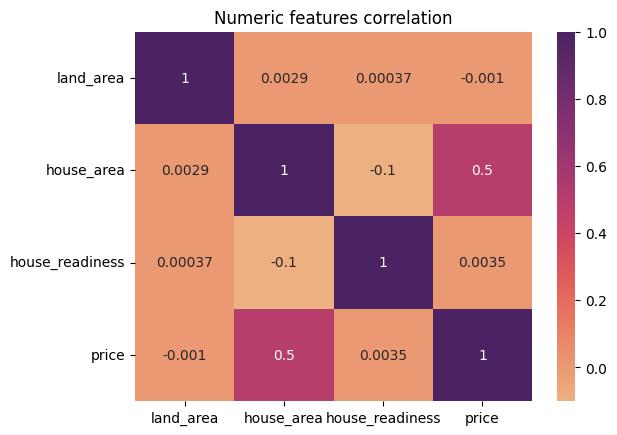

In [1308]:
sns.heatmap(df.loc[:,num_features].corr(), cmap='flare', annot=True).set(title='Numeric features correlation');

In [1309]:
categories = df[cat_features].nunique().sort_values(ascending=False)
display(categories)

index                     14570
house_coordinates         11933
Номер договора             9586
Населенный пункт           4518
Улица                      2250
Направление                 817
Сельсовет                   789
Номер дома                  416
Микрорайон                  160
house_year                  122
Район                       118
Материал стен                22
Район города                 15
Материал крыши               13
Вода                         11
Отопление                    10
Ремонт                        7
Статус земли                  7
Область                       6
Условия продажи               6
Канализация                   5
Электроснабжение              5
Тип объекта                   5
house_levels                  5
Газ                           5
Телефон                       3
Пруд на участке               1
Элитный коттедж               1
Бассейн                       1
Аукцион                       1
Новостройка                   1
Беседка 

In [1310]:
df.isna().sum().sort_values(ascending=False)

Аукцион                   14492
Бассейн                   14379
Пруд на участке           14180
Элитный коттедж           14164
Строительные материалы    14015
Новостройка               13917
Камин                     13537
Теплица                   13243
Беседка                   13128
Микрорайон                12884
Район города              12825
Ремонт                    12552
Телефон                   12440
Баня                      12377
Мебель                    11590
Гараж                     11262
Направление               11242
Сад                       10749
Водоем                    10013
Номер дома                 9883
Ландшафтный дизайн         9797
Возможен торг              9251
Рядом лес                  9246
Хозпостройки               8858
Сельсовет                  7143
Улица                      6569
Номер договора             4711
Газ                        4687
house_year                 3789
Материал крыши             3711
Канализация                3704
house_le

In [1311]:
df.drop(['Аукцион', 'index', 'Номер договора', 'Улица', 'Номер дома', 'Микрорайон', 'Район города', 'Возможен торг'], axis=1, inplace=True)
cat_features = [item for item in df.columns if item not in num_features]

categories = df.loc[:, cat_features].nunique().sort_values(ascending=False) #categories[categories<=3]  
categories


house_coordinates         11933
Населенный пункт           4518
Направление                 817
Сельсовет                   789
house_year                  122
Район                       118
Материал стен                22
Материал крыши               13
Вода                         11
Отопление                    10
Статус земли                  7
Ремонт                        7
Условия продажи               6
Область                       6
house_levels                  5
Тип объекта                   5
Канализация                   5
Электроснабжение              5
Газ                           5
Телефон                       3
Гараж                         1
Строительные материалы        1
Пруд на участке               1
Элитный коттедж               1
Бассейн                       1
Новостройка                   1
Беседка                       1
Камин                         1
Сад                           1
Мебель                        1
Теплица                       1
Ландшафт

### Binary categories

In [1312]:
bin_categories = categories[categories<=3]
print(bin_categories)

Телефон                   3
Гараж                     1
Строительные материалы    1
Пруд на участке           1
Элитный коттедж           1
Бассейн                   1
Новостройка               1
Беседка                   1
Камин                     1
Сад                       1
Мебель                    1
Теплица                   1
Ландшафтный дизайн        1
Водоем                    1
Рядом лес                 1
Баня                      1
Хозпостройки              1
dtype: int64


In [1313]:
display(df['Беседка'].value_counts())
display(df['Камин'].value_counts())
display(df['Телефон'].value_counts())

Беседка
1.0    1443
Name: count, dtype: int64

Камин
['Да']    1034
Name: count, dtype: int64

Телефон
['Есть']             2115
['2', 'телефона']      13
['3', 'телефона']       3
Name: count, dtype: int64

In [1314]:
class BIN_Transformer(TransformerMixin, BaseEstimator):
    '''Transform binary categories'''

    def __init__(self, bin_categories):
        self.categories = bin_categories
        

    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        for item in self.categories.index:
            X[item] = X[item].apply(lambda x: 0 if pd.isna(x) else 1)     
        
        return X
    

bin_treat = BIN_Transformer(bin_categories)
df = bin_treat.transform(df)

In [1315]:
df.shape

(14571, 40)

### Multi options categories 

In [1316]:
multi_categories = categories[categories>3]
display(multi_categories)


house_coordinates    11933
Населенный пункт      4518
Направление            817
Сельсовет              789
house_year             122
Район                  118
Материал стен           22
Материал крыши          13
Вода                    11
Отопление               10
Статус земли             7
Ремонт                   7
Условия продажи          6
Область                  6
house_levels             5
Тип объекта              5
Канализация              5
Электроснабжение         5
Газ                      5
dtype: int64

In [1317]:
df[multi_categories.index].isna().sum().sort_values(ascending=False) #/ df.shape[0]

Ремонт               12552
Направление          11242
Сельсовет             7143
Газ                   4687
house_year            3789
Материал крыши        3711
Канализация           3704
house_levels          2944
Отопление             2873
Электроснабжение      2201
Условия продажи       2144
Вода                  2072
Статус земли          1953
Материал стен         1795
Район                  175
Населенный пункт         0
Область                  0
Тип объекта              0
house_coordinates        0
dtype: int64

In [1318]:
# fillna
fill_na_net = ['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ']
fill_na_mode = ['Материал крыши', 'house_levels', 'Статус земли', 'Материал стен', 'Тип объекта', 'Условия продажи', 'Ремонт']
fill_na_manage = ['Направление', 'Сельсовет', 'Район', 'Область', 'house_year', 'Населенный пункт']


### Multi options categories. Fill NAN with 'net'

In [1319]:
print(stat_compare(df,'Канализация', "['С/у', 'на', 'улице']", "['Нет']"))
print(stat_compare(df,'Канализация', "['Местная']", "['Центральная']"))

print(stat_compare(df,'Электроснабжение', "['Рядом']", "['Нет']"))
print(stat_compare(df,'Электроснабжение', "['Есть']", "['220В']"))

print(stat_compare(df,'Вода', "['Рядом', 'колодец']", "['Рядом']"))
print(stat_compare(df,'Вода', "['Рядом', 'водопровод']", "['Рядом']"))
print(stat_compare(df,'Вода', "['Нет']", "['Рядом']"))

print(stat_compare(df,'Отопление', "['На', 'газу']", "['Паровое']"))
print(stat_compare(df,'Отопление', "['Паровое', 'на', 'твёрдом', 'топливе']", "['Паровое']"))
print(stat_compare(df,'Отопление', "['Паровое', 'на', 'жидком', 'топливе']", "['Паровое']"))

КАНАЛИЗАЦИЯ ['С/у', 'на', 'улице'] (1), ['Нет'] (1): EQUAL --> ['С/у', 'на', 'улице']
КАНАЛИЗАЦИЯ ['Местная'] (1), ['Центральная'] (1): not equal
ЭЛЕКТРОСНАБЖЕНИЕ ['Рядом'] (1), ['Нет'] (1): not equal
ЭЛЕКТРОСНАБЖЕНИЕ ['Есть'] (1), ['220В'] (1): not equal
ВОДА ['Рядом', 'колодец'] (1), ['Рядом'] (1): not equal
ВОДА ['Рядом', 'водопровод'] (1), ['Рядом'] (1): EQUAL --> ['Рядом']
ВОДА ['Нет'] (1), ['Рядом'] (1): not equal
ОТОПЛЕНИЕ ['На', 'газу'] (1), ['Паровое'] (1): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'твёрдом', 'топливе'] (1), ['Паровое'] (1): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'жидком', 'топливе'] (1), ['Паровое'] (1): not equal


In [1320]:
class CAT_1_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with "no" '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Газ'] = X['Газ'].map({
            "['Рядом']":'рядом', 
            "['Есть']":'есть', 
            "['Нет']":'нет',
            "['Баллон']":'нет',
            "['Магистральный']":'есть',            
            }) 

        X['Канализация'] = X['Канализация'].map({
            "['С/у', 'на', 'улице']":'с/у наружн.', 
            "['Местная']":'местная', 
            "['Есть']":'есть', 
            "['Центральная']":'центральн.', 
            "['Нет']":'нет',
            })

        X['Электроснабжение'] = X['Электроснабжение'].map({
            "['Есть']":'есть', 
            "['220В']":'есть', 
            "['Рядом']":'рядом', 
            "['380В']":'380В', 
            "['Нет']":'нет',
            })

        X['Отопление'] = X['Отопление'].map({
            "['На', 'газу']":'паровое г.',
            "['Печное']":'печь', 
            "['Электрическое']":'электрич.',
            "['Нет']":'нет', 
            "['Центральное']":'центральн.',
            "['Паровое', 'на', 'твёрдом', 'топливе']":'паровое т.', 
            "['Паровое', 'на', 'газу']":'паровое г.', 
            "['Паровое', 'на', 'жидком', 'топливе']":'паровое ж.',
            "['Паровое']":'паровое',
            "['Альтернативные', 'источники']":'альтерн.',             
            })
        
        X['Вода'] = X['Вода'].map({
            "['Центральный', 'водопровод']":'водопровод',
            "['Скважина']":'скважина', 
            "['Колодец']":'колодец',
            "['Сезонная']":'сезонная', 
            "['Горячая']":'горячая',
            "['Холодная']":'холодная',
            "['Рядом']":'рядом',
            "['Рядом', 'колодец']":'рядом колодец',
            "['Нет']":'нет',
            "['Рядом', 'водопровод']":'рядом',
            "['Водопровод']":'водопровод'
            })

        


        X[self.categories] = X[self.categories].fillna('нет')

        return X
    

cat_1_treat = CAT_1_Transformer(fill_na_net)
df = cat_1_treat.transform(df)

In [1321]:
df.shape

(14571, 40)

In [1322]:
#draw_categories(df,fill_na_net)

### Multi options categories. Fill NAN with mode-value

In [1323]:
fill_na_mode

['Материал крыши',
 'house_levels',
 'Статус земли',
 'Материал стен',
 'Тип объекта',
 'Условия продажи',
 'Ремонт']

In [1324]:
print(stat_compare(df,'Материал стен', "['Блок', 'газосиликатный']", "['Блочный']"))
print(stat_compare(df,'Материал стен', "['Силикатные', 'блоки']", "['Блочный']"))
print(stat_compare(df,'Материал стен', "['Блок', 'газосиликатный']", "['Силикатные', 'блоки']"))
print(stat_compare(df,'Материал стен', "['Белый', 'кирпич']", "['Кирпичный']"))
print(stat_compare(df,'Материал стен', "['Белый', 'кирпич']", "['Красный', 'кирпич']"))
print(stat_compare(df,'Материал стен', "['Красный', 'кирпич']", "['Кирпичный']"))
print(stat_compare(df,'Материал стен', "['Бревенчатый']", "['Сруб']"))

print(stat_compare(df,'Материал крыши', "['Металло-черепица']", "['Металл']"))
print(stat_compare(df,'Материал крыши', "['Ондулин']", "['Евро-шифер']"))
print(stat_compare(df,'Материал крыши', "['Мягкая', 'черепица']", "['Битумная', 'черепица']"))
print(stat_compare(df,'Материал крыши', "['Жесть']", "['Металл']"))
print(stat_compare(df,'Материал крыши', "['Рубероид']", "['Гидроизоляция']"))

print(stat_compare(df,'Тип объекта', "['Таунхаус']", "['Коттедж']"))

print(stat_compare(df,'Ремонт', "['Евроотделка,', 'отделка', 'деревом']", "['Евроотделка']"))
print(stat_compare(df,'Ремонт', "['Не', 'достроен,', 'отделка', 'деревом']", "['Не', 'достроен']"))


МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Блочный'] (1): not equal
МАТЕРИАЛ СТЕН ['Силикатные', 'блоки'] (1), ['Блочный'] (1): not equal


МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Силикатные', 'блоки'] (1): not equal
МАТЕРИАЛ СТЕН ['Белый', 'кирпич'] (1), ['Кирпичный'] (1): not equal
МАТЕРИАЛ СТЕН ['Белый', 'кирпич'] (1), ['Красный', 'кирпич'] (1): not equal
МАТЕРИАЛ СТЕН ['Красный', 'кирпич'] (1), ['Кирпичный'] (1): not equal
МАТЕРИАЛ СТЕН ['Бревенчатый'] (1), ['Сруб'] (1): EQUAL --> ['Сруб']
МАТЕРИАЛ КРЫШИ ['Металло-черепица'] (1), ['Металл'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Ондулин'] (1), ['Евро-шифер'] (1): EQUAL --> ['Ондулин']
МАТЕРИАЛ КРЫШИ ['Мягкая', 'черепица'] (1), ['Битумная', 'черепица'] (1): EQUAL --> ['Мягкая', 'черепица']
МАТЕРИАЛ КРЫШИ ['Жесть'] (1), ['Металл'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Рубероид'] (1), ['Гидроизоляция'] (1): not equal
ТИП ОБЪЕКТА ['Таунхаус'] (0), ['Коттедж'] (1): not equal
РЕМОНТ ['Евроотделка,', 'отделка', 'деревом'] (1), ['Евроотделка'] (1): not equal
РЕМОНТ ['Не', 'достроен,', 'отделка', 'деревом'] (1), ['Не', 'достроен'] (1): EQUAL --> ['Не', 'достроен']


In [1325]:
class CAT_2_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with mode-value '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''

        X['Тип объекта'] = X['Тип объекта'].map({
            "['Дом']":'дом',
            "['Дача']":'дача',
            "['Коттедж']":'коттедж', 
            "['Полдома']":'полдома',
            "['Таунхаус']":'таунхаус', 
            })

        X['Материал стен'] = X['Материал стен'].map({
            "['Дерево']":'дерево', 
            "['Кирпичный']":'кирпич', 
            "['Блок', 'газосиликатный']":'блок г/с', 
            "['Блочный']":'блок',
            "['Дерево,', 'обложено', 'кирпичом']":'дер., кирпич',
            "['Сруб']":'сруб',
            "['Брус', 'профилированный']":'брус профил.',
            "['Сборно-щитовой']":'сб-щитовой',
            "['Шлакобетон']":'шлакобетон',            
            "['Керамзитбетон']":'керамзитобетон',
            "['Каркасный', 'деревянный']":'каркасн. дер.',
            "['Белый', 'кирпич']":'кирпич бел.',
            "['Бревенчатый']":'сруб',
            "['Силикатные', 'блоки']":'блок г/с',
            "['Красный', 'кирпич']":'кирпич кр.',
            "['Панельный']":'панельн.',
            "['Брус', 'оцилиндрованный']":'брус оцил.',
            "['Каркасно-засыпной']":'другой',
            "['Облицовочный', 'кирпич']":'другой',
            "['Брус', 'клееный']":'другой',
            "['Монолитно-каркасный']":'другой',
            "['Блок-комнаты']":'другой'
            })

        X['Материал крыши'] = X['Материал крыши'].map({
            "['Шифер']":'шифер',
            "['Металло-черепица']":'черепица мет.', 
            "['Мягкая', 'черепица']":'черепица мяг.',
            "['Черепица']":'черепица',
            "['Ондулин']":'ондулин', 
            "['Металл']":'металл',
            "['Жесть']":'жесть',
            "['Евро-шифер']":'ондулин',
            "['Битумная', 'черепица']":'черепица мяг.',
            "['Рубероид']":'другой',
            "['Гидроизоляция']":'другой',
            "['Доски']":'другой',
            "['Природные', 'материалы']":'другой'
            })

        X['Статус земли'] = X['Статус земли'].map({
            "['Частная', 'собственность']":'частная',
            "['Пожизненно', 'наследуемое', 'владение']":'пожизн. насл.',
            "['Частная']":'частная', 
            "['Аренда']":'аренда',
            "['Пожизненноe', 'наследуемое', 'владение']":'пожизн. насл.', 
            "['Другое']":'другое', 
            "['Пользование']":'другое'
            })
        
        X['Ремонт'] = X['Ремонт'].map({
            "['Отделка', 'деревом']":'отделка дер.', 
            "['Не', 'достроен']":'не достроен',
            "['Евроотделка']":'евроотделка',
            "['Евроотделка,', 'отделка', 'деревом']":'евроотделка дер.',
            "['Не', 'достроен,', 'отделка', 'деревом']":'не достроен',
            "['Евроотделка,', 'не', 'достроен']": 'не достроен',
            "['Евроотделка,', 'не', 'достроен,', 'отделка', 'деревом']":'не достроен'
            })

        #largest_roof = df['Материал крыши'].value_counts().nlargest(10).index
        #X['Материал крыши'] = X['Материал крыши'].apply(lambda x: x if x in largest_roof else ('другой' if x is not np.nan else x))

        #largest_wall = df['Материал стен'].value_counts().nlargest(10).index
        #X['Материал стен'] = X['Материал стен'].apply(lambda x: x if x in largest_wall else 'другой')
        
        X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        X.drop(['Условия продажи'], axis=1, inplace=True)
        #X = X[X['Тип объекта']=='дача']
        
        return X
    

cat_2_treat = CAT_2_Transformer(fill_na_mode)
df = cat_2_treat.transform(df)

In [1326]:
df.shape

(14571, 39)

In [1327]:
#draw_categories(df,['Материал крыши', 'house_levels','Статус земли','Материал стен','Тип объекта'], 14, 40)

### Multi options categories. Manage to fill NAN

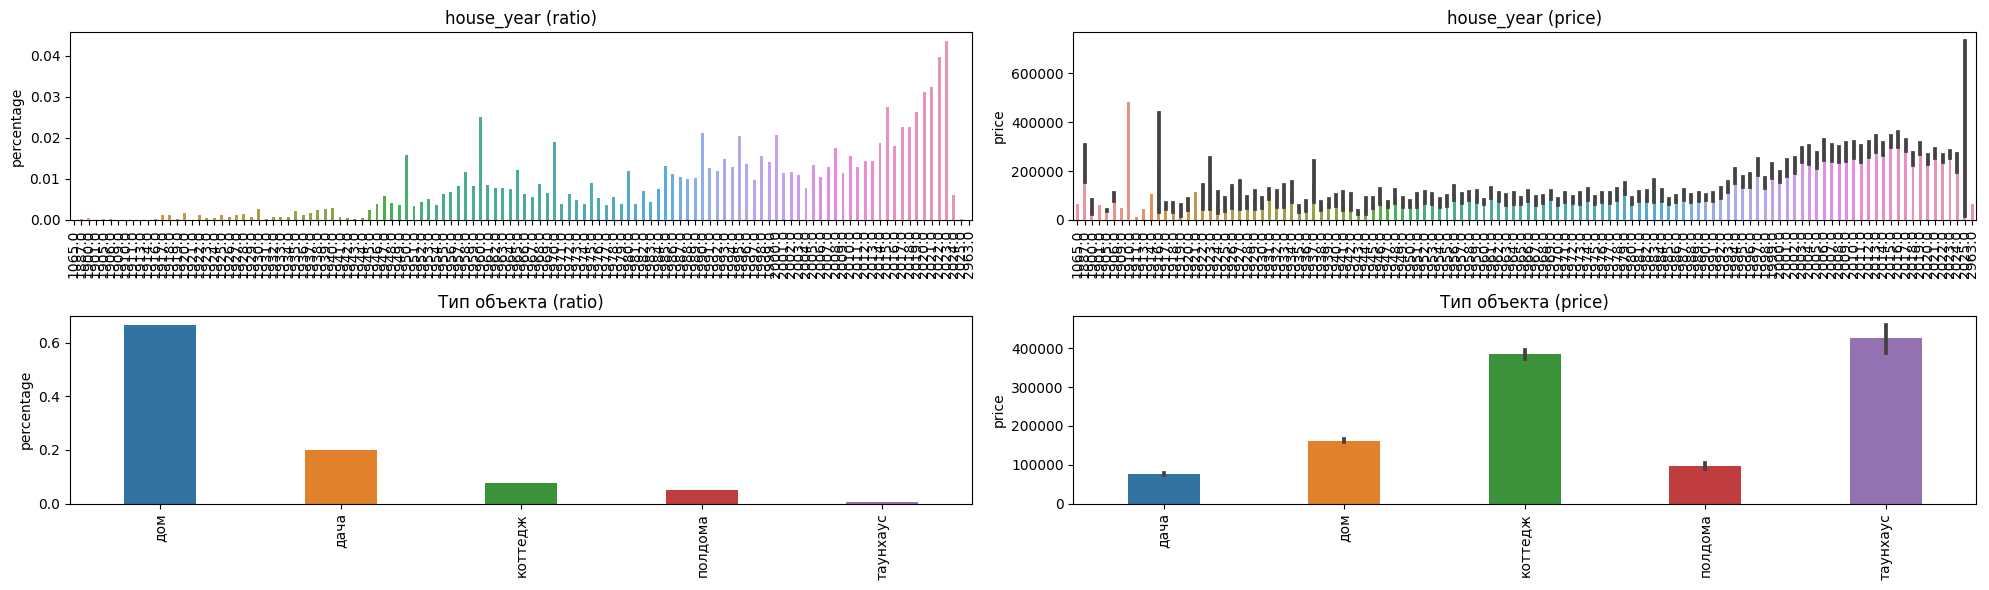

In [1328]:
draw_categories(df,['house_year', 'Тип объекта'],20,90)

In [1329]:
print(df['Населенный пункт'].isna().sum())
df['Населенный пункт'].value_counts().index

0


Index(['['г.', 'Брест']', '['г.', 'Гомель']', '['г.', 'Барановичи']',
       '['г.', 'Витебск']', '['г.', 'Гродно']', '['г.', 'Минск']',
       '['г.', 'Орша']', '['г.', 'Борисов']', '['г.', 'Могилев']',
       '['аг.', 'Колодищи']',
       ...
       '['д.', 'Красная', 'нива']', '['д.', 'Селище', 'Малое']',
       '['д.', 'Замужанье']', '['с/т', 'ПЕЛЕНГ']', '['с/т', 'Лисички']',
       '['снп', 'Грицевец']', '['с/т', 'СУЗОРЬЕ']', '['с/т', 'Проектировщик']',
       '['д.', 'Брюшково']', '['д.', 'Орля']'],
      dtype='object', name='Населенный пункт', length=4518)

In [1330]:
df[df['Район'].isna()].loc[:,['Населенный пункт','Район','Область']]['Населенный пункт'].value_counts()

Населенный пункт
['г.', 'Минск']                     170
['г.п.', 'Вороново']                  2
['с/т', 'Родничок']                   1
['г.п.', 'Руба']                      1
['с/т', 'Свислочский', 'Урожай']      1
Name: count, dtype: int64

In [1331]:
class CAT_3_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Направление'] = X['Направление'].apply(
            lambda x: re.findall(r'\'(\w{5,})\,.', x)[0] if x is not np.nan else x)
        X['Направление'] = X['Направление'].fillna('unknown')
        X['in_city'] = X['Населенный пункт'].apply(
            lambda x: 1 if len(re.findall(r'\'([г]{1}\.)\'', x))==1 else 0)
        X['Населенный пункт'] = X['Населенный пункт'].apply(
            lambda x: (' ').join(re.findall(r'\'([А-Яа-я0-9]{1,})\'', x.replace('-','').replace('/','').replace('.',''))))
        
        #X['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        #X['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])
        #X = X[(X['house_year']>1900) & (X['house_year']<2025)]
        X = X[~((X['house_year']<1950) & (X['price']>1.5*X['price'].median()))]
        X['year_group'] = pd.cut(
            X.house_year, [0,1900,1920,1940,1960,1980,2000,9999], 
            labels = ['<1900','1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000+']) 
        X['year_group'] = X['year_group'].fillna(X['year_group'].mode()[0])


        X['Область'] = X['Область'].map({
            "['Гомельская', 'область']":'Гомель', 
            "['Минская', 'область']":'Минск', 
            "['Гродненская', 'область']":'Гродно', 
            "['Брестская', 'область']":'Брест',
            "['Могилевская', 'область']":'Могилев',
            "['Витебская', 'область']":'Витебск'
            })
        
        X['Район'] = X['Район'].apply(
            lambda x: re.findall(r'\'([А-Яа-я.]{1,})\'',x.replace('-',''))[0] if x is not np.nan else x)
        X.loc[X[X['Населенный пункт']=="г Минск"].index,'Район'] = 'Минск'
        X = X[X['Район'].notna()]
                
        #df_district = pd.read_csv('data/districts.csv').rename(columns={'Unnamed: 0':'Район'})
        #X = pd.merge(X, df_district, how='left', on='Район')

        #largest_districts = X['Район'].value_counts().nlargest(30).index
        #X['Район'] = X['Район'].apply(lambda x: x if x in largest_districts else 'другой')
        
        largest_towns = X['Населенный пункт'].value_counts().nlargest(20).index
        X['Населенный пункт'] = X['Населенный пункт'].apply(lambda x: x if x in largest_towns else 'другой')
        
        X.drop(['house_year', 'Сельсовет'], axis=1, inplace=True)
                

        return X
    

cat_3_treat = CAT_3_Transformer(fill_na_manage)
df = cat_3_treat.transform(df)


In [1332]:
temp = df.groupby('Населенный пункт')['price'].agg(['count','median']).sort_values(by='count', ascending=False).reset_index()
temp

,Населенный пункт,count,median
0,другой,11305,77810.0
1,г Брест,933,275579.0
2,г Гомель,226,139037.5
3,г Барановичи,204,129684.0
4,г Витебск,186,86087.0
5,г Гродно,175,275575.0
6,г Минск,164,387431.0
7,г Орша,138,92400.0
8,г Борисов,131,113474.0
9,г Могилев,125,142652.0


In [1333]:
df.shape

(14494, 39)

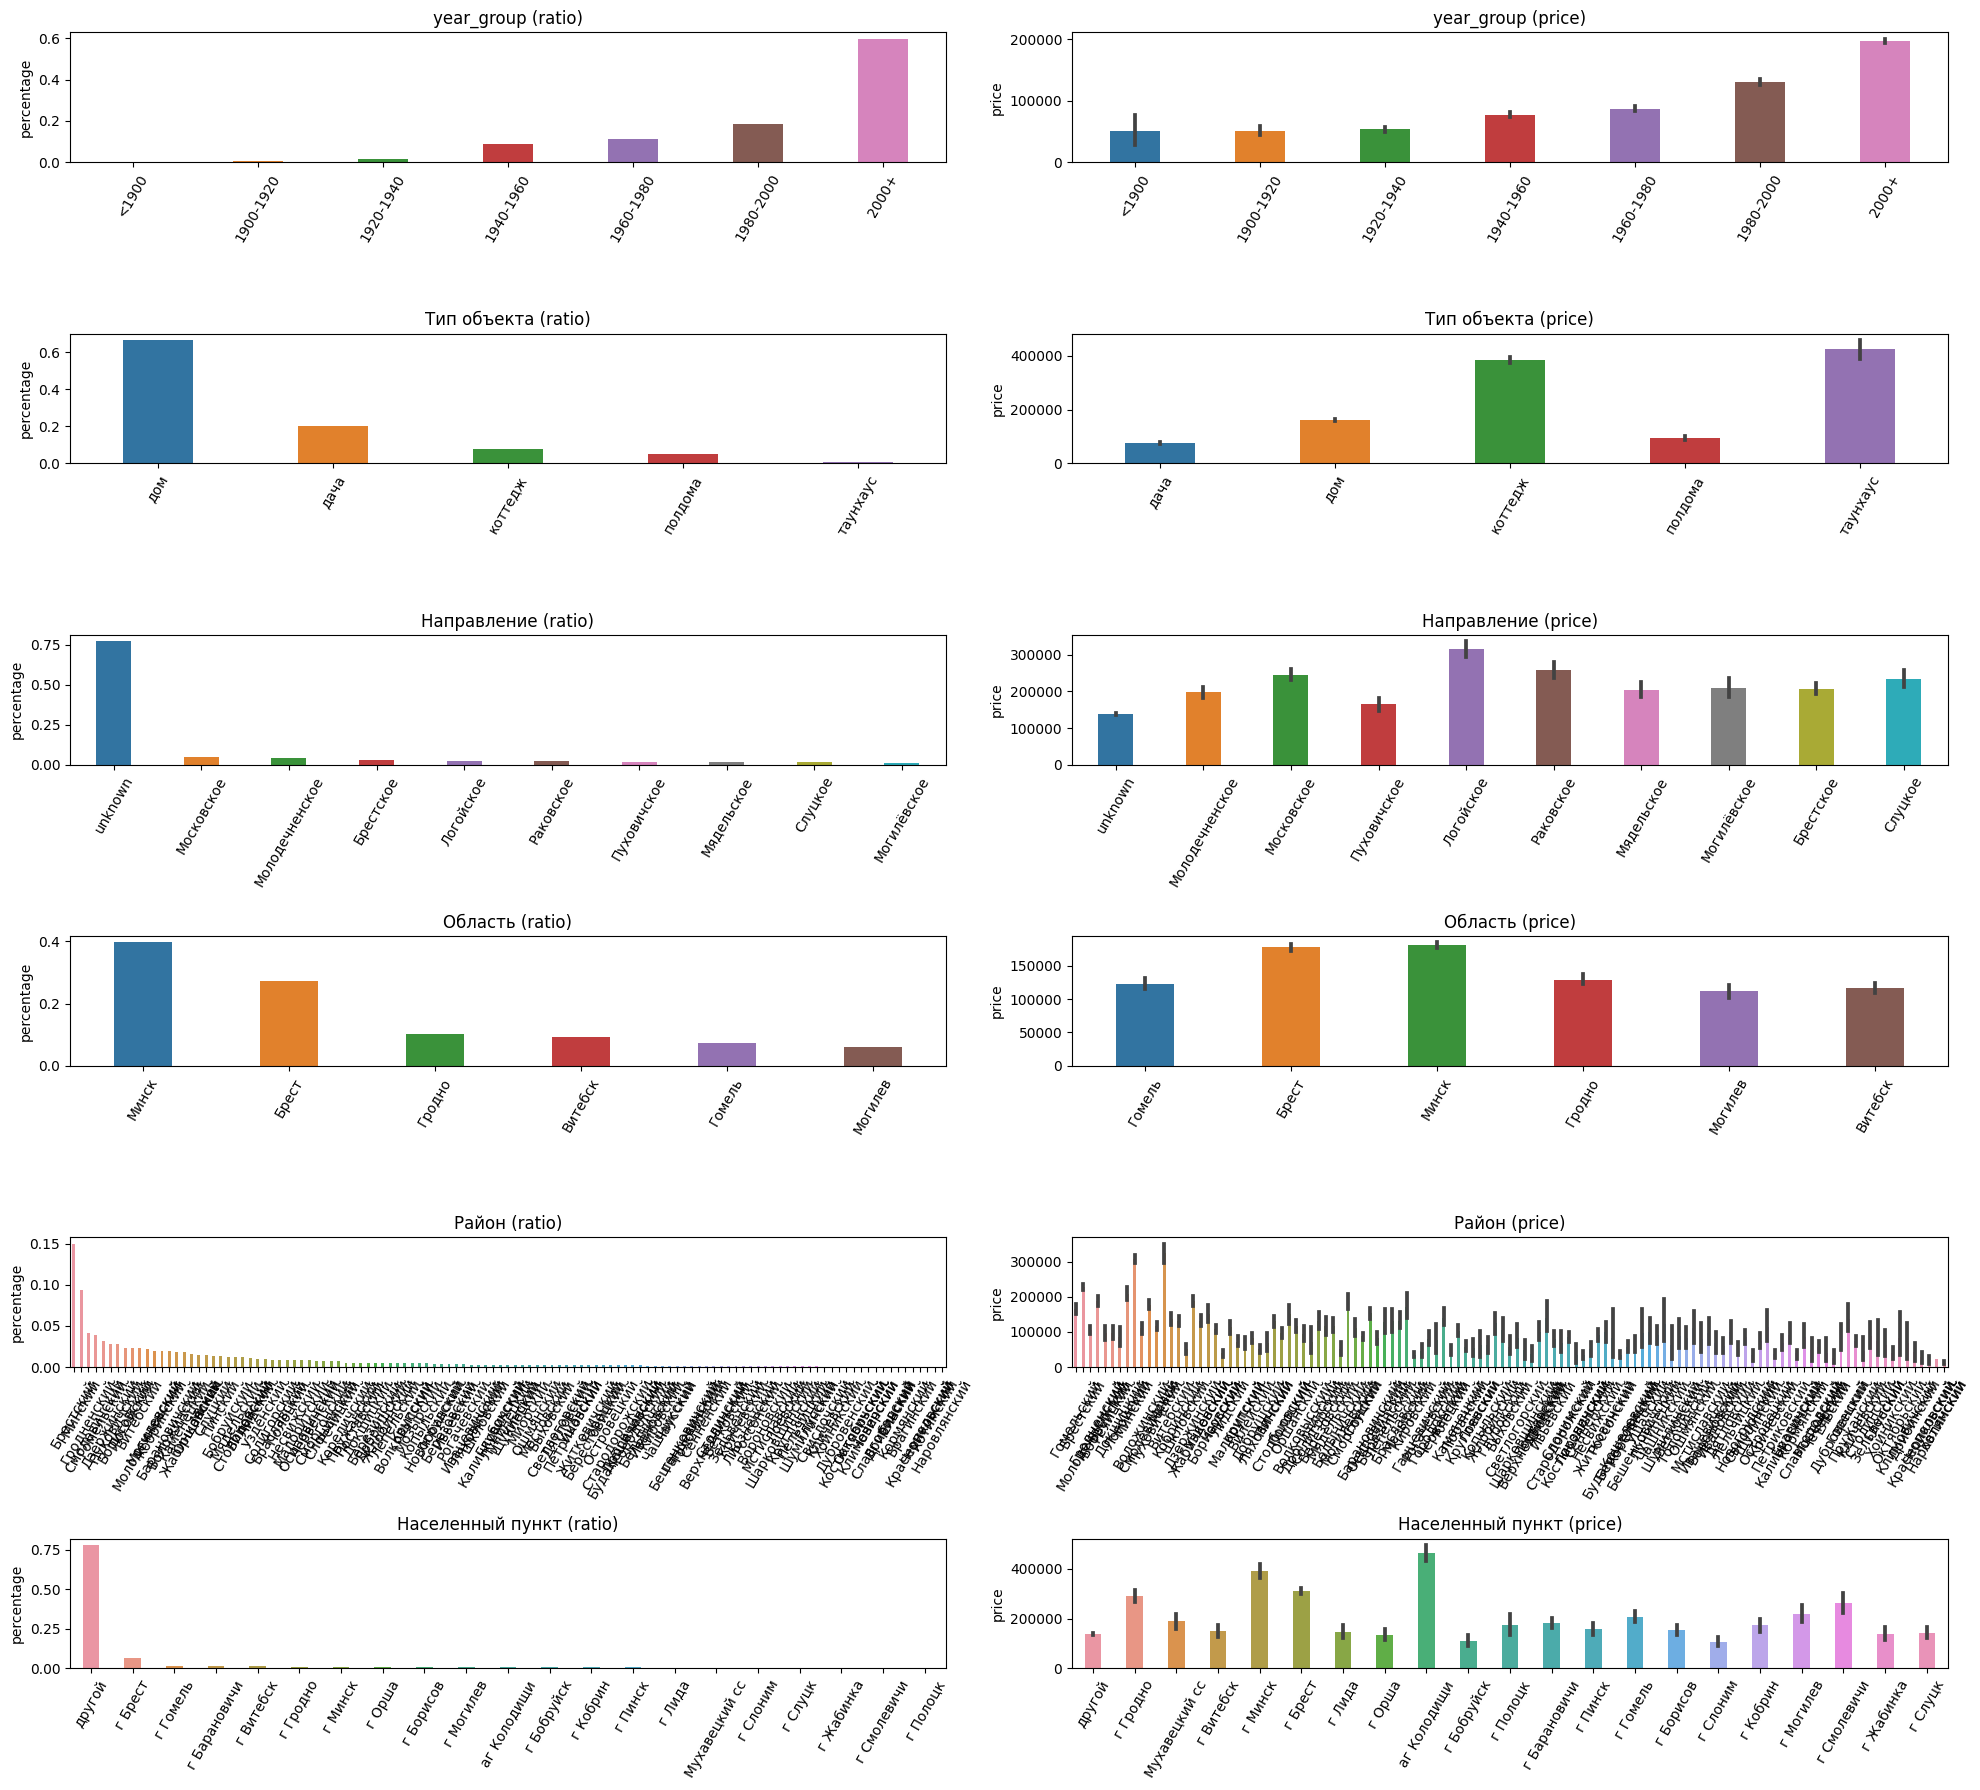

In [1334]:
draw_categories(df,['year_group', 'Тип объекта','Направление', 'Область', 'Район', 'Населенный пункт'],20,60)

In [1335]:
district_dict = dict()


#for i in df['Район'].unique():
#    try:
#        district_dict[i] = get_district_details(i + ' район, Беларусь')
#    except:
#        print(i, "couldn't get data")
#        continue

#district_dict['Славгородский'] = [(53.2643, 30.5947), (53.2643, 30.5947)]

#df_district = pd.DataFrame(district_dict, index=['district_center_coordinates', 'district_city_coordinates']).T
#df_district.to_csv('data/districts.csv')



In [1336]:
print(df.shape)


(14494, 39)


### New features

In [1337]:
def get_location(name):
    try:
        g = geocoder.bing(name, key='AgY4Qy8qL2I1oMf6xu6SSpqncKEFzpjZIKzs3Y_lhKvdA4cRPMUpBEIDmgXxm5_e')
        results = g.json
        #print(name, results['lat'], results['lng'])
        return (results['lat'], results['lng'])
    except:
        print('exception', name)
        return name


regions_dict = dict()
regions = df['Область'].unique()
for item in regions:
    if type(item) is str:
        regions_dict[item] = get_location(item + ', беларусь')
    else:
        continue

regions_dict


{'Гомель': (52.4191246, 30.97227287),
 'Брест': (52.0941124, 23.7319088),
 'Минск': (53.897686, 27.54942131),
 'Гродно': (53.67042542, 23.82331085),
 'Могилев': (53.90841293, 30.34563446),
 'Витебск': (55.1845932, 30.20467567)}

In [1338]:
df['regional_center_coordinates'] = df['Область'].apply(lambda x: str(regions_dict[x]) )

In [1339]:
districts_df = pd.read_csv('data/districts.csv').rename(columns={'Unnamed: 0':'Район'})
districts_df.loc[districts_df.shape[0]] = ['Минск','(53.55, 27.33)','(53.55, 27.33)']
df = pd.merge(df, districts_df, how='left', on='Район')
districts_df.tail()
df.tail()


,Тип объекта,Материал стен,Материал крыши,Отопление,Канализация,Электроснабжение,Вода,Телефон,Область,Район,...,house_area,house_levels,house_readiness,house_coordinates,price,in_city,year_group,regional_center_coordinates,district_center_coordinates,district_city_coordinates
14489,коттедж,керамзитобетон,черепица мет.,нет,нет,есть,нет,1,Минск,Минский,...,195.0,3.0,60.0,"(53.950711, 27.786994)",421473,0,2000+,"(53.897686, 27.54942131)","(53.54, 27.34)","(53.55, 27.33)"
14490,коттедж,кирпич,шифер,нет,нет,нет,нет,0,Витебск,Витебский,...,240.0,2.0,30.0,"(55.175365, 30.271554)",126442,1,2000+,"(55.1845932, 30.20467567)","(55.11, 30.1)","(55.11, 30.1)"
14491,дом,дерево,шифер,печь,местная,нет,водопровод,0,Минск,Борисовский,...,83.0,1.0,100.0,"(54.23539, 28.554604)",100505,1,2000+,"(53.897686, 27.54942131)","(54.14, 28.3)","(54.14, 28.3)"
14492,дом,дерево,шифер,нет,с/у наружн.,есть,колодец,0,Брест,Жабинковский,...,53.0,1.0,100.0,"(52.117351, 23.990695)",38905,0,1940-1960,"(52.0941124, 23.7319088)","(52.1206, 24.0118)","(52.1202, 24.0124)"
14493,дом,дерево,шифер,печь,нет,есть,водопровод,0,Брест,Каменецкий,...,28.3,1.0,100.0,"(52.230964, 23.315368)",15886,0,2000+,"(52.0941124, 23.7319088)","(52.232, 23.4846)","(52.24, 23.48)"


In [1340]:
def get_distance(d1,d2,extra=0):
    coord1 = str(d1).replace(',',' ').lstrip('(').rstrip(')').split()
    coord2 = d2.replace(',',' ').lstrip('(').rstrip(')').split()
    distance = geopy.distance.geodesic((float(coord1[0]),float(coord1[1])), (float(coord2[0]),float(coord2[1]))).km

    if extra == 0:
        return round(distance,1)
    else:
        distances = dict()
        for key in regions_dict:
            distances[key] = geopy.distance.geodesic((float(coord1[0]),float(coord1[1])), (regions_dict[key][0],regions_dict[key][1])).km
        distance_region_min = min(distances.values())
        return(round(distance,1), round(distance_region_min,1))

#df['distance_house_district_center'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['district_center_coordinates']), axis=1)
df['distance_house_district_city'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['district_city_coordinates']), axis=1)
#df['distance_house_region'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates'],1)[0], axis=1)
df['distance_house_region_min'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates'],1)[1], axis=1)
df['distance_house_minsk'] = df.apply(lambda x: get_distance(x['house_coordinates'], str(regions_dict['Минск'])), axis=1)

df['distances_multiply'] = df['distance_house_minsk'] * df['distance_house_region_min'] * df['distance_house_district_city']
df['distances_sum'] = df['distance_house_minsk'] + df['distance_house_region_min'] + df['distance_house_district_city']


In [1341]:
#df.loc[500:520, ['Населенный пункт','Район','distance_house_district_center', 'distance_house_district_city','distance_house_region_min','distance_house_minsk', ]]

In [1342]:
largest_districts = df['Район'].value_counts().nlargest(30).index
df['Район'] = df['Район'].apply(lambda x: x if x in largest_districts else 'другой')

In [1343]:
#sns.heatmap(df.loc[:,num_features+['distances_multiply','distances_sum','distance_house_district_city','distance_house_region_min','distance_house_minsk']].corr(), cmap='flare', annot=True).set(title='Numeric features correlation');

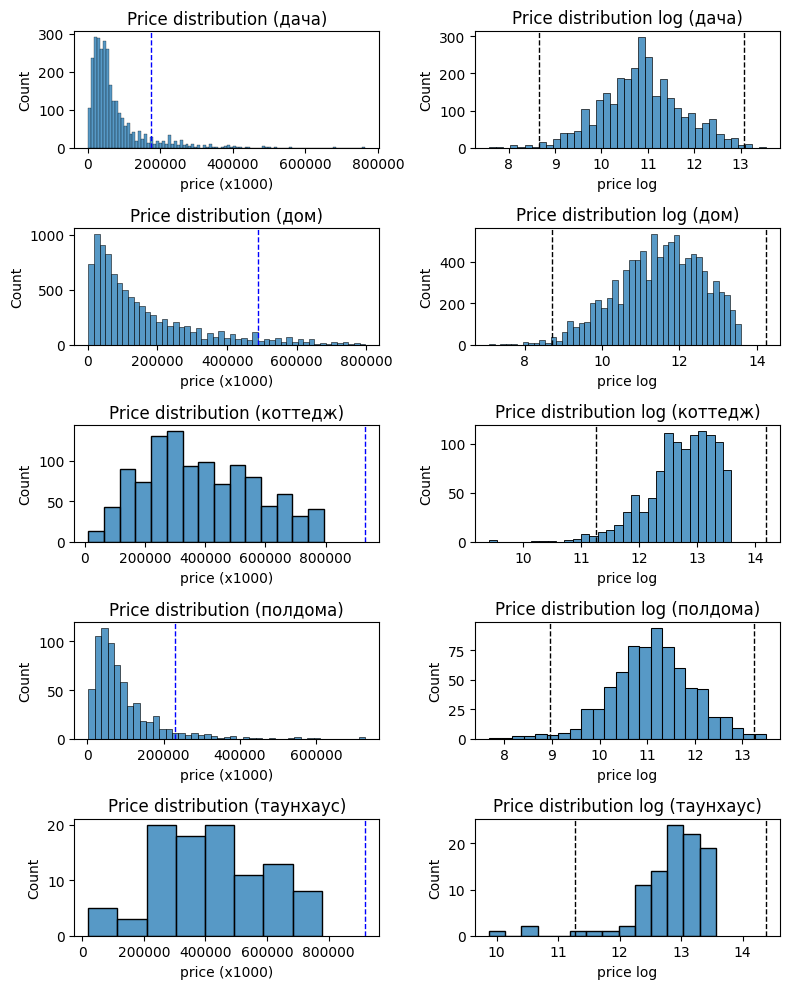

In [1344]:
temp = df['Тип объекта'].unique()
f,a = plt.subplots(len(temp),2, figsize=(8,2*len(temp)))
for i,k in enumerate(temp):
    x = df[df['Тип объекта']==k]['price']
    sns.histplot(x, ax=a[i,0]).set(title=f'Price distribution ({k})', xlabel='price (x1000)');
    #a[i,0].axvline(x.mean(), color='r', lw=1)
    #a[i,0].axvline(x.quantile(0.25) - 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
    a[i,0].axvline(x.quantile(0.75) + 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
    
    sns.histplot(np.log(df[df['Тип объекта']==k]['price']), ax=a[i,1]).set(title=f'Price distribution log ({k})', xlabel='price log');
    #a[i,1].axvline(x.median(), color='k', lw=1)
    a[i,1].axvline(np.log(x).mean()+ 2.5 * np.log(x).std(), color='k', ls='--', lw=1)
    a[i,1].axvline(np.log(x).mean()- 2.5 * np.log(x).std(), color='k', ls='--', lw=1)

plt.tight_layout()

In [1345]:
print(f"DF shape before outliers removing: {df.shape}")
df_cleaned = pd.DataFrame()
for i in df['Тип объекта'].unique():
    df_cleaned = pd.concat([df_cleaned, outliers_iqr_mod(df[df['Тип объекта']==i], 'price', log_scale=False)], axis=0)
    #df_cleaned = pd.concat([df_cleaned, outliers_z_score(df[df['Тип объекта']==i], 'price', log_scale=True)], axis=0)
    print(f"Dataframe's shape after cleaning outliers from object {i}: {df_cleaned.shape}")


df_cleaned.shape

DF shape before outliers removing: (14494, 47)
Dataframe's shape after cleaning outliers from object дача: (2640, 47)
Dataframe's shape after cleaning outliers from object дом: (11750, 47)
Dataframe's shape after cleaning outliers from object коттедж: (12852, 47)
Dataframe's shape after cleaning outliers from object полдома: (13507, 47)
Dataframe's shape after cleaning outliers from object таунхаус: (13605, 47)


(13605, 47)

In [1346]:
ohe_list = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 
            'Вода','Область',  'Газ',  'Ремонт', 'Район','year_group', 'Тип объекта', 'Населенный пункт']#'Статус земли', 'Направление', 



encoder = ce.OneHotEncoder(cols=ohe_list, use_cat_names=True)
add = encoder.fit_transform(df_cleaned.loc[:,ohe_list])
dff = pd.concat([df_cleaned,add], axis=1).drop(ohe_list, axis=1)

dff = dff.drop(['house_coordinates','regional_center_coordinates',  'Статус земли', 'Направление', 'district_center_coordinates','district_city_coordinates'], axis=1)
#dff = dff.drop(['distances_sum','distance_house_district_city','distance_house_region_min','distance_house_minsk'], axis=1) # 'distances_multiply',

dff.head(3)

,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Населенный пункт_г Барановичи,Населенный пункт_г Пинск,Населенный пункт_г Гомель,Населенный пункт_г Борисов,Населенный пункт_г Кобрин,Населенный пункт_г Слоним,Населенный пункт_г Смолевичи,Населенный пункт_г Жабинка,Населенный пункт_г Могилев,Населенный пункт_г Слуцк
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1347]:
print(dff.shape)


(13605, 156)


### Models

In [1348]:
X = dff.drop('price', axis=1)
y = dff['price']
col_names = X.columns



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
y_train_log = np.log(y_train)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_df = pd.DataFrame(X_train, columns=col_names)
X_test_df = pd.DataFrame(X_test, columns=col_names)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')


X_train_df.head()


Train shape: (10884, 155)
Test shape: (2721, 155)


,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Населенный пункт_г Барановичи,Населенный пункт_г Пинск,Населенный пункт_г Гомель,Населенный пункт_г Борисов,Населенный пункт_г Кобрин,Населенный пункт_г Слоним,Населенный пункт_г Смолевичи,Населенный пункт_г Жабинка,Населенный пункт_г Могилев,Населенный пункт_г Слуцк
11347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5809,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1299,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11649,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1349]:
def get_metrics(y_train, y_train_predict, y_test, y_test_predict):
    #print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    #print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    #print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    #print('Train MSE: {:.3f}'.format(metrics.mean_squared_error(y_train, y_train_predict)*100))
    #print('\n')
    #print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    #print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    #print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    #print('Test MSE: {:.3f}'.format(metrics.mean_squared_error(y_test, y_test_predict)*100))

    train_r2 = round(metrics.r2_score(y_train, y_train_predict),2)
    train_mae = round(metrics.mean_absolute_error(y_train, y_train_predict),2)
    train_mape = round(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100,2)
    test_r2 = round(metrics.r2_score(y_test, y_test_predict),2)
    test_mae = round(metrics.mean_absolute_error(y_test, y_test_predict),2)
    test_mape = round(round(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100,2),2)
    err_dict = {'r2':[train_r2,test_r2], 'mae':[train_mae,test_mae],'mape':[train_mape,test_mape]}
    return pd.DataFrame(err_dict, index=['TRAIN', 'TEST'])

In [1350]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"_______lr | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae,mape
TRAIN,0.72,51595.06,79.89
TEST,0.73,51525.14,83.22


In [1351]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train, y_train) 

y_train_pred = gs.predict(X_train)
y_test_pred = gs.predict(X_test)


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"______gs | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae,mape
TRAIN,0.80,41619.21,58.06
TEST,0.78,43566.93,65.61


In [1352]:
from  sklearn.ensemble import IsolationForest
# Isolation Forest, или iForest. Это алгоритм обнаружения аномалий на основе дерева. Данный метод стремится изолировать аномалии, 
# которые немногочисленны и различаются по пространству признаков
 
# ищем выбросы в обучающей выборке
print(X_train_scaled.shape, y_train.shape)
iso = IsolationForest(contamination=0.1) #, random_state=42) #  от 0.0 до 0.5
iso.fit(X_train_df.values)
y_predicted = iso.predict(X_train_df.values)

mask = y_predicted != -1
X_train_new, y_train_new = X_train[mask], y_train[mask]
print(X_train_new.shape, y_train_new.shape)


(10884, 155) (10884,)
(9795, 155) (9795,)


In [1353]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train_new, y_train_new) 

y_train_pred = gs.predict(X_train)
y_test_pred = gs.predict(X_test)

errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"__gs_iso | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae,mape
TRAIN,0.79,41881.06,57.76
TEST,0.78,43560.59,64.37


In [1354]:
def optuna_rf(trial):
    """_summary_

    Args:
        trial (_type_): _description_

    Returns:
        _type_: _description_
    """
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=33
        )
  
    model.fit(X_train, y_train)
    #score = metrics.r2_score(y_train_log, model.predict(X_train_scaled))
    score_test = metrics.r2_score(y_test, model.predict(X_test))
    #score_train = metrics.r2_score(y_train, np.exp(model.predict(X_train_scaled)))
    score = score_test #/ (score_train-score_test)

    return score


study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
study.optimize(optuna_rf, n_trials=10)

print(f"Best hyperparameters {study.best_params}")
print(f"r2-score for TRAIN set: {study.best_value}")

#--> Best hyperparameters {'n_estimators': 129, 'max_depth': 25, 'min_samples_leaf': 10}

[I 2024-04-28 11:52:46,917] A new study created in memory with name: RandomForestRegressor
[I 2024-04-28 11:53:00,707] Trial 0 finished with value: 0.7792561851998341 and parameters: {'n_estimators': 193, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7792561851998341.
[I 2024-04-28 11:53:10,282] Trial 1 finished with value: 0.7875478506596505 and parameters: {'n_estimators': 115, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7875478506596505.
[I 2024-04-28 11:53:18,576] Trial 2 finished with value: 0.7783463889792692 and parameters: {'n_estimators': 124, 'max_depth': 14, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7875478506596505.
[I 2024-04-28 11:53:25,655] Trial 3 finished with value: 0.7763537899455373 and parameters: {'n_estimators': 103, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7875478506596505.
[I 2024-04-28 11:53:33,900] Trial 4 finished with value: 0.7703263253349752 and parameters: {'n_e

Best hyperparameters {'n_estimators': 115, 'max_depth': 20, 'min_samples_leaf': 3}
r2-score for TRAIN set: 0.7875478506596505


In [1355]:
rfr = RandomForestRegressor(**study.best_params,random_state=33)
#rfr = RandomForestRegressor(n_estimators= 129, max_depth = 25, min_samples_leaf = 10,random_state=33)

rfr.fit(X_train, y_train)

y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"_____rfr | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae,mape
TRAIN,0.93,23935.62,34.57
TEST,0.79,42663.71,61.66


In [1356]:
imp_df = pd.DataFrame({'index': X_train.columns, 'importance':rfr.feature_importances_}).sort_values(by='importance', ascending=False).nlargest(columns='importance',n=40)
imp_df#.nlargest(50)

,index,importance
18,house_area,0.483748
131,Тип объекта_коттедж,0.087339
24,distance_house_minsk,0.052158
23,distance_house_region_min,0.046070
25,distances_multiply,0.041285
54,Отопление_паровое г.,0.030889
22,distance_house_district_city,0.022439
17,land_area,0.021889
26,distances_sum,0.019216
43,Материал крыши_шифер,0.016286


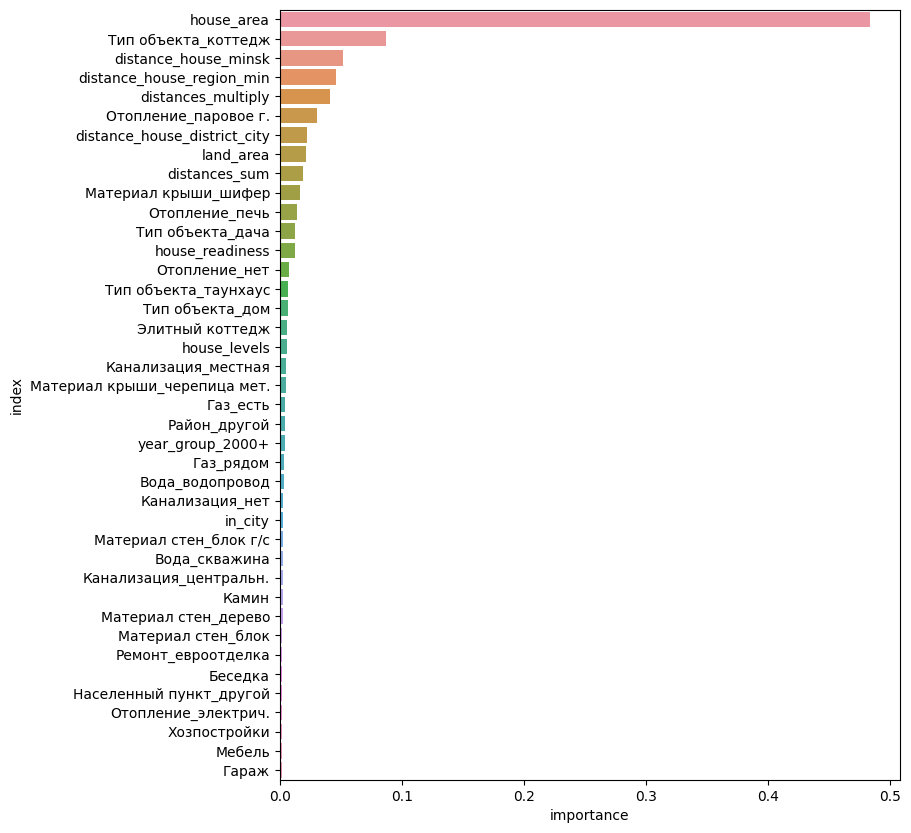

In [1357]:
f,a = plt.subplots(figsize=(8,10))
sns.barplot(y=imp_df['index'], x=imp_df.importance, orient='h');

In [1358]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train[imp_df['index'].values[:30]], y_train) 

y_train_pred = gs.predict(X_train[imp_df['index'].values[:30]])
y_test_pred = gs.predict(X_test[imp_df['index'].values[:30]])


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"__gs_imp | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae,mape
TRAIN,0.79,42371.89,58.93
TEST,0.77,44198.10,64.40


In [1359]:
train_scores_r2 = []
test_scores_r2 = []
train_scores_mae = []
test_scores_mae = []

for i in np.arange(20, X_train.shape[1],20):
    selector = SelectKBest(f_regression, k=i)
    selector.fit(X_train, y_train)
    best_fea = selector.get_feature_names_out()

    params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

    gs = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=33), 
        param_grid=params,
        scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
        cv=3, 
        n_jobs = -1
    )  

    gs.fit(X_train_df[best_fea], y_train) 

    y_train_pred = gs.predict(X_train_df[best_fea])
    y_test_pred = gs.predict(X_test_df[best_fea])

    train_scores_r2.append(metrics.r2_score(y_train, y_train_pred))
    test_scores_r2.append(metrics.r2_score(y_test, y_test_pred))
    train_scores_mae.append(metrics.mean_absolute_error(y_train, y_train_pred))
    test_scores_mae.append(metrics.mean_absolute_error(y_test, y_test_pred))
    #metrics.mean_absolute_error(y_test, y_test_pred)


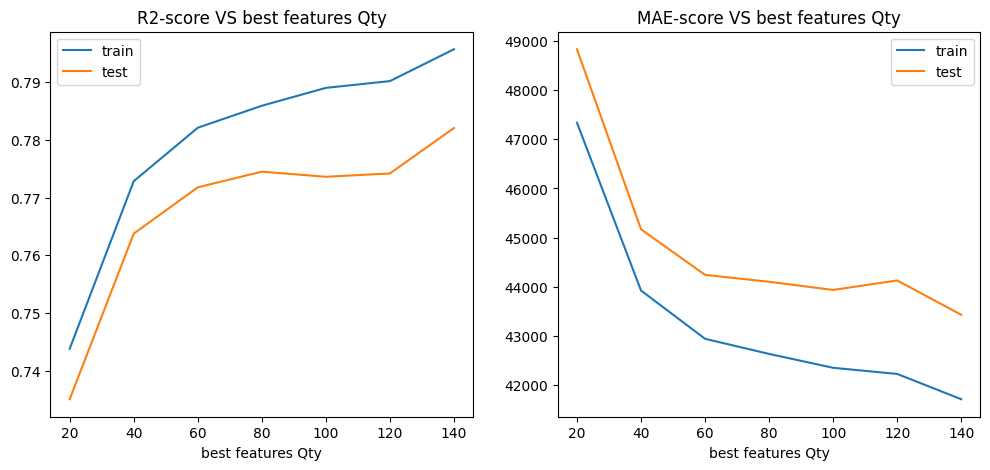

In [1360]:
f,a = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_r2, ax=a[0], label='train').set(title='R2-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_r2, ax=a[0], label='test');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_mae, ax=a[1], label='train').set(title='MAE-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_mae, ax=a[1], label='test');

In [1361]:
selector = SelectKBest(f_regression, k=60)
selector.fit(X_train, y_train_log)
 
best_fea = selector.get_feature_names_out()
best_fea

array(['Гараж', 'Хозпостройки', 'Рядом лес', 'Камин', 'Беседка',
       'Новостройка', 'Элитный коттедж', 'house_area', 'house_levels',
       'in_city', 'distance_house_region_min', 'distances_multiply',
       'distances_sum', 'Материал стен_дерево', 'Материал стен_блок г/с',
       'Материал стен_блок', 'Материал стен_керамзитобетон',
       'Материал крыши_шифер', 'Материал крыши_черепица мет.',
       'Материал крыши_ондулин', 'Материал крыши_черепица мяг.',
       'Материал крыши_черепица', 'Отопление_печь', 'Отопление_электрич.',
       'Отопление_паровое г.', 'Канализация_местная', 'Канализация_нет',
       'Канализация_с/у наружн.', 'Канализация_есть',
       'Канализация_центральн.', 'Электроснабжение_380В', 'Вода_скважина',
       'Вода_нет', 'Вода_сезонная', 'Вода_горячая', 'Вода_водопровод',
       'Вода_колодец', 'Вода_рядом колодец', 'Область_Минск',
       'Область_Витебск', 'Газ_нет', 'Газ_есть', 'Ремонт_отделка дер.',
       'Ремонт_евроотделка дер.', 'Ремонт_евроотде

In [1362]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train[best_fea], y_train) 

y_train_pred = gs.predict(X_train[best_fea])
y_test_pred = gs.predict(X_test[best_fea])


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred)
display(errs)
logger.info(f"gs_kbest | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae,mape
TRAIN,0.78,43311.88,58.96
TEST,0.77,44371.31,64.73


In [1363]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

In [ ]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('linr',  linear_model.LinearRegression())
    #('dt',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    #final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    final_estimator=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
)
# Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()), ('linr', LinearRegression())],
                  final_estimator=RandomForestRegressor(max_depth=10,
                                                        random_state=42))

In [ ]:
with open('myfile.pkl', 'wb') as output:
    pickle.dump(regressor, output)

with open('myfile.pkl', 'rb') as pkl_file:
    regressor_from_file = pickle.load(pkl_file)

In [ ]:
import joblib

# Загружаем датасет о диабете
X, y = load_diabetes(return_X_y=True)
# Обучаем модель линейной регрессии
regressor = LinearRegression()
regressor.fit(X, y)
# Производим сериализацию и сохраняем результат в файл формата .joblib
joblib.dump(regressor, 'regr.joblib')


# Десериализуем модель из файла
clf_from_jobliv = joblib.load('regr.joblib') 
# Сравниваем предсказания
all(regressor.predict(X) == clf_from_jobliv.predict(X))